### Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import MultilabelDataset

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

cuda:0
1
NVIDIA GeForce RTX 4050 Laptop GPU


In [3]:
# !gdown drive.com

### Dataset Dataloader

In [4]:
bs = 64
crop_size = 224

In [5]:
train_transform = transforms.Compose([
  transforms.RandomRotation(10),
  transforms.RandomResizedCrop(crop_size, scale=(0,7, 1)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
test_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

In [7]:
train_set = MultilabelDataset("data/train_label.csv", "data/train/", transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = MultilabelDataset("data/test_label.csv", "data/test/", transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [8]:
label2cat = train_set.classes
label2cat

['desert', 'mountains', 'sea', 'sunset', 'trees']

### Architecture & Config

#### Contoh pakai Pretrained-Model

In [9]:
from torchvision.models import mobilenet_v2
mnet = mobilenet_v2(pretrained=True)

for param in mnet.parameters():
  param.requires_grad = False

c:\Users\ibrak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ibrak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
mnet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
mnet.classifier = nn.Sequential(
  nn.Linear(1280, len(label2cat)),
  nn.Sigmoid()
)

In [12]:
mnet.classifier

Sequential(
  (0): Linear(in_features=1280, out_features=5, bias=True)
  (1): Sigmoid()
)

In [13]:
class customeMNetV2(nn.Module):
  def __init__(self, output_size) :
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()
    self.mnet.classifier = nn.Sequential(
      nn.Linear(1280, output_size),
      nn.Sigmoid()
    )
  
  def forward(self, x) :
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False
  
  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [14]:
config = set_config({
  "output_size" : len(label2cat),
  "batch_size" : bs,
  "crop_size" : crop_size
})

### Fase 1 Adaptation (lr Standar + Patience Kecil)

In [15]:
model = customeMNetV2(config.output_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
Callback = Callback(model, config, early_stop_patience=2, outdir="model")

In [22]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == "train": model.train()
  elif mode == "test": model.eval()

  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == "train" :
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  
  cost = cost / len(dataset)
  return cost

In [23]:
def fitModel():
  while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device) 
    with torch.no_grad():
      test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # Logging
    Callback.log(train_cost, test_cost)

    # Checkpoint
    Callback.save_checkpoint()

    #Runtime Plotting
    Callback.cost_runtime_plotting()

    #Early Stopping
    if Callback.early_stopping (model, monitor="test_cost"):
      Callback.plot_cost()
      break

Test: 100%|██████████| 7/7 [00:06<00:00,  1.10it/s]



Epoch     1
Train_cost  = 0.3888 | Test_cost  = 0.3221 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]



Epoch     2
Train_cost  = 0.3348 | Test_cost  = 0.2823 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.36it/s]



Epoch     3
Train_cost  = 0.3192 | Test_cost  = 0.2752 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]



Epoch     4
Train_cost  = 0.2963 | Test_cost  = 0.2538 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.54it/s]



Epoch     5
Train_cost  = 0.2923 | Test_cost  = 0.2512 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.45it/s]



Epoch     6
Train_cost  = 0.2831 | Test_cost  = 0.2492 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]



Epoch     7
Train_cost  = 0.2722 | Test_cost  = 0.2430 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]



Epoch     8
Train_cost  = 0.2710 | Test_cost  = 0.2377 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]



Epoch     9
Train_cost  = 0.2645 | Test_cost  = 0.2315 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]



Epoch    10
Train_cost  = 0.2614 | Test_cost  = 0.2270 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.04it/s]



Epoch    11
Train_cost  = 0.2522 | Test_cost  = 0.2227 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.12it/s]



Epoch    12
Train_cost  = 0.2521 | Test_cost  = 0.2214 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]



Epoch    13
Train_cost  = 0.2480 | Test_cost  = 0.2260 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2214


Test: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]



Epoch    14
Train_cost  = 0.2524 | Test_cost  = 0.2207 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]



Epoch    15
Train_cost  = 0.2608 | Test_cost  = 0.2239 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2207


Test: 100%|██████████| 7/7 [00:01<00:00,  6.03it/s]



Epoch    16
Train_cost  = 0.2577 | Test_cost  = 0.2226 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2207
==> Execute Early Stopping at epoch: 16 | Best test_cost: 0.2207
==> Best model is saved at model


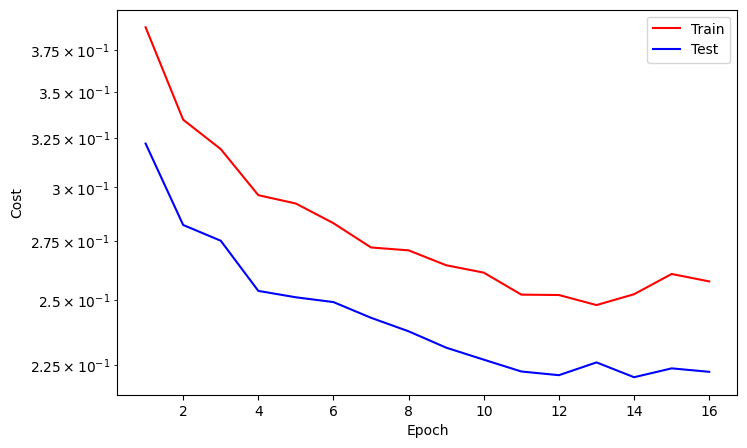

In [24]:
fitModel()

### Fase 2 : Fine Tunning (lr dikecilin, patiecnce ditambah)

In [25]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
Callback.reset_early_stop()
Callback.early_stop_patience = 5

Test: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]



Epoch    17
Train_cost  = 0.2440 | Test_cost  = 0.2018 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.22it/s]



Epoch    18
Train_cost  = 0.2324 | Test_cost  = 0.1988 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]



Epoch    19
Train_cost  = 0.2181 | Test_cost  = 0.2013 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1988


Test: 100%|██████████| 7/7 [00:01<00:00,  6.21it/s]


Epoch    20
Train_cost  = 0.2087 | Test_cost  = 0.1930 | 


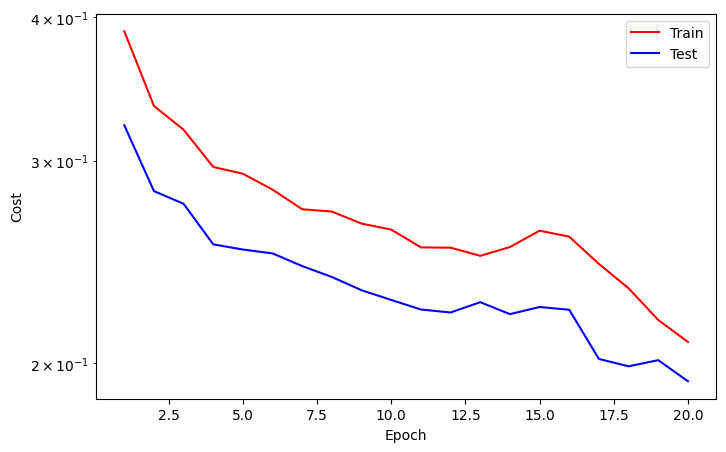

Test: 100%|██████████| 7/7 [00:01<00:00,  6.44it/s]



Epoch    21
Train_cost  = 0.2100 | Test_cost  = 0.1936 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1930


Test: 100%|██████████| 7/7 [00:01<00:00,  6.24it/s]



Epoch    22
Train_cost  = 0.2099 | Test_cost  = 0.1936 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1930


Test: 100%|██████████| 7/7 [00:01<00:00,  6.48it/s]



Epoch    23
Train_cost  = 0.2035 | Test_cost  = 0.1839 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]



Epoch    24
Train_cost  = 0.2016 | Test_cost  = 0.1818 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.39it/s]



Epoch    25
Train_cost  = 0.1951 | Test_cost  = 0.1814 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]



Epoch    26
Train_cost  = 0.1892 | Test_cost  = 0.1795 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.32it/s]



Epoch    27
Train_cost  = 0.1877 | Test_cost  = 0.1725 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.34it/s]



Epoch    28
Train_cost  = 0.1899 | Test_cost  = 0.1720 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]



Epoch    29
Train_cost  = 0.1802 | Test_cost  = 0.1699 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]



Epoch    30
Train_cost  = 0.1811 | Test_cost  = 0.1685 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.33it/s]



Epoch    31
Train_cost  = 0.1774 | Test_cost  = 0.1695 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1685


Test: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]



Epoch    32
Train_cost  = 0.1734 | Test_cost  = 0.1653 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.64it/s]



Epoch    33
Train_cost  = 0.1751 | Test_cost  = 0.1636 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]



Epoch    34
Train_cost  = 0.1700 | Test_cost  = 0.1655 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1636


Test: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]



Epoch    35
Train_cost  = 0.1624 | Test_cost  = 0.1650 | 
==> EarlyStop patience =  2 | Best test_cost: 0.1636


Test: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]



Epoch    36
Train_cost  = 0.1624 | Test_cost  = 0.1604 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]



Epoch    37
Train_cost  = 0.1592 | Test_cost  = 0.1671 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1604


Test: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]



Epoch    38
Train_cost  = 0.1640 | Test_cost  = 0.1585 | 


Test: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]



Epoch    39
Train_cost  = 0.1656 | Test_cost  = 0.1588 | 
==> EarlyStop patience =  1 | Best test_cost: 0.1585


Test: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]



Epoch    40
Train_cost  = 0.1621 | Test_cost  = 0.1629 | 


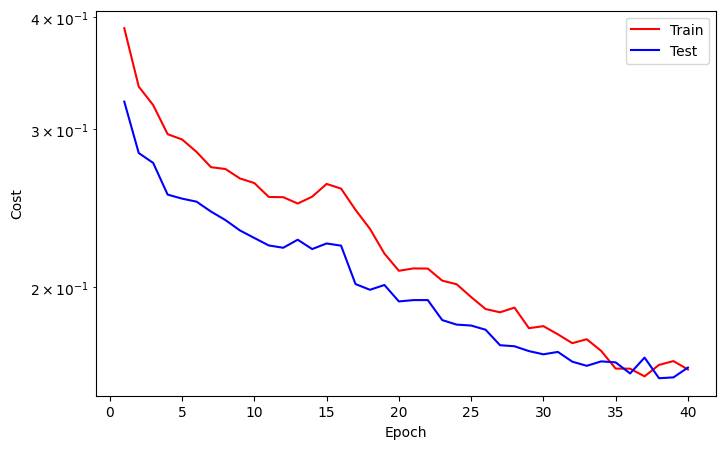

==> EarlyStop patience =  2 | Best test_cost: 0.1585


Test: 100%|██████████| 7/7 [00:01<00:00,  5.87it/s]



Epoch    41
Train_cost  = 0.1539 | Test_cost  = 0.1599 | 
==> EarlyStop patience =  3 | Best test_cost: 0.1585


Test: 100%|██████████| 7/7 [00:01<00:00,  6.08it/s]



Epoch    42
Train_cost  = 0.1520 | Test_cost  = 0.1627 | 
==> EarlyStop patience =  4 | Best test_cost: 0.1585


Test: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]



Epoch    43
Train_cost  = 0.1518 | Test_cost  = 0.1638 | 
==> EarlyStop patience =  5 | Best test_cost: 0.1585
==> Execute Early Stopping at epoch: 43 | Best test_cost: 0.1585
==> Best model is saved at model


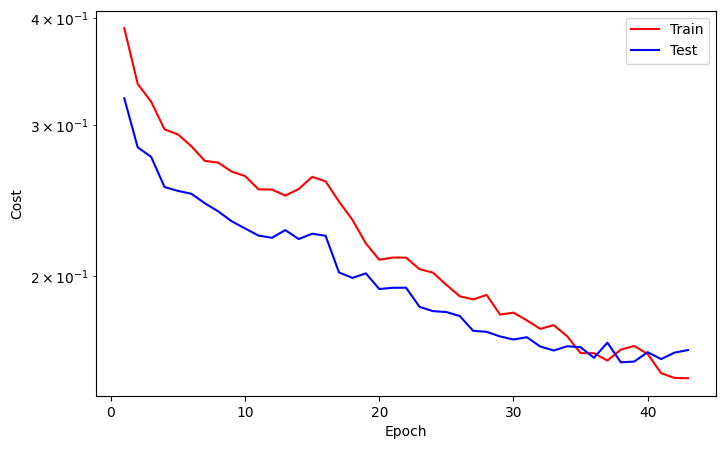

In [26]:
fitModel()

### Prediction

In [27]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [28]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = (output > 0.5).to(torch.float32)

preds

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1

In [ ]:
torch.save(model.state_dict(), "customeMNetV2.pth")

### Visualisasi : Sanity Check

In [31]:
def convert_to_label(x):
  return [label for pred, label in zip(x, label2cat) if pred==1]

def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

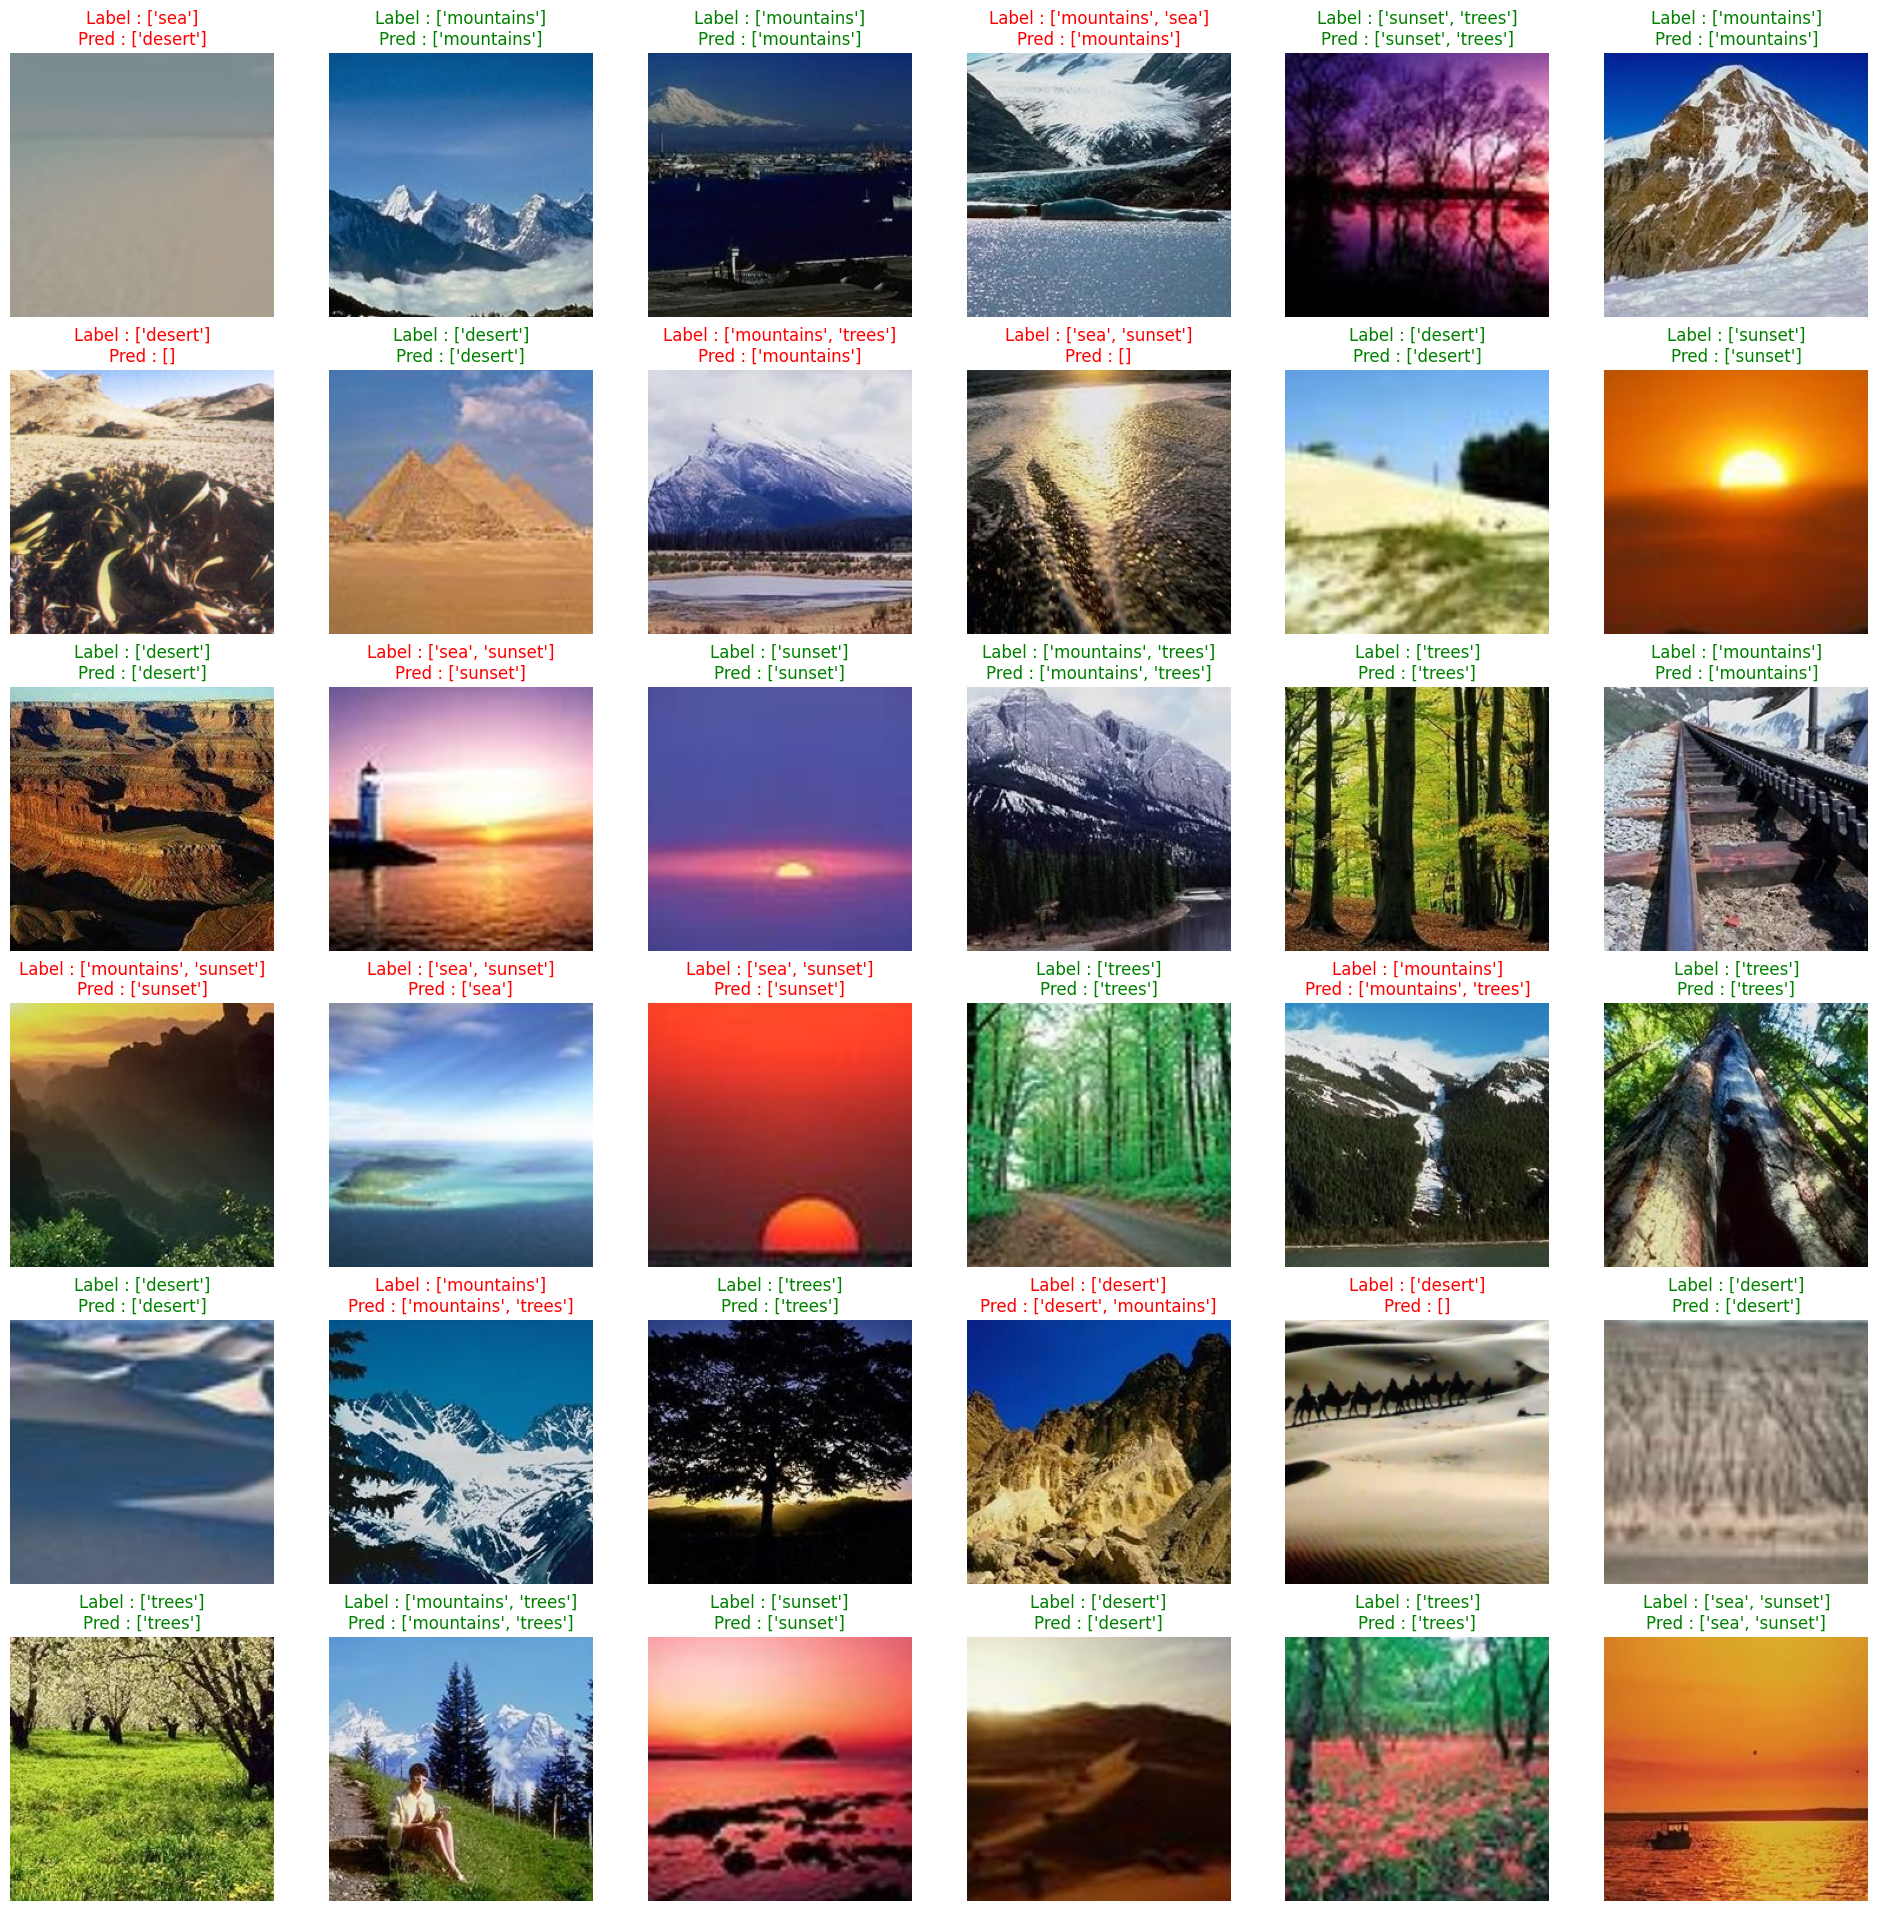

In [32]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))

for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
  font = {"color": "r"} if (pred != label).any() else {"color": "g"}
  label, pred = convert_to_label(label), convert_to_label(pred)
  ax.set_title(f"Label : {label}\nPred : {pred}", fontdict = font)
  ax.axis("off")